# Proyecto Final - Unit 25: Applied Machine Learning

**Alumno:** Pablo Soto  
**Programa:** Pearson HND PD Computer Science & AI / Data Science & AI  
**Fecha:** Enero 2026  

## Índice de contenidos

1. Introducción y Objetivos  
2. Marco Teórico  
3. Desarrollo del Proyecto  
   3.1 EDA (Análisis Exploratorio)  
   3.2 Preprocesamiento e Ingeniería de Features  
   3.3 Entrenamiento y Evaluación de Modelos  
   3.4 Mejora mediante Técnicas de IA Generativa  
   3.5 Visualizaciones y Narrativas  
   3.6 Arquitectura y Ciclo de Feedback  
4. Resultados y Discusión  
5. Conclusiones  
6. Bibliografía  
7. Anexos  

## Referencias académicas obligatorias (formato Harvard)

Todo el trabajo debe estar respaldado por una investigación y referenciado a lo largo del texto mediante el sistema Harvard.  
El uso incorrecto de las referencias puede dar lugar a plagio si no se aplica correctamente.


## 1. Introducción y Objetivos

### Contexto del Problema (Business Understanding)

El mercado de criptomonedas, especialmente Solana (SOL), es altamente volátil debido a factores macroeconómicos, noticias, adopción y especulación.  
Predecir precios diarios ayuda a traders e inversores a tomar decisiones informadas, aunque ningún modelo garantiza éxito futuro (Géron, 2019).

### Hipótesis Inicial

Se esperaba que un modelo LSTM capturara mejor las dependencias temporales que un Random Forest clásico, y que un ensemble mejorara la precisión general.

### Valor para el Usuario Final

Traders minoristas y analistas crypto pueden usar la aplicación para obtener predicciones rápidas, visualizaciones de indicadores técnicos (RSI, MACD) y análisis de errores.  
La herramienta no constituye asesoramiento financiero.


## 2. Marco Teórico

### Taxonomía de Algoritmos de Aprendizaje Automático (LO1, P1-P2, M1)

- Aprendizaje supervisado orientado a regresión continua (precio de cierre).  
- Random Forest como modelo ensemble robusto frente a overfitting y adecuado para relaciones no lineales (Géron, 2019).  
- LSTM como red neuronal recurrente especializada en series temporales y dependencias de largo plazo (Hochreiter y Schmidhuber, 1997).

Los conceptos de pesos, bias y backpropagation vistos en ejercicios previos se aplican directamente en el entrenamiento de redes LSTM mediante Keras y TensorFlow.

### Justificación de los Modelos (LO2, P3-P4, M2)

Random Forest se utiliza como modelo baseline por su rapidez y explicabilidad.  
LSTM se emplea para capturar patrones secuenciales complejos presentes en precios de criptomonedas.


In [15]:
# Importaciones globales (ejecutar primero)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from src.data_handler import load_data, prepare_features
from src.predictor import load_models, predict_next_days

%matplotlib inline


## 3. Desarrollo del Proyecto

### 3.1 EDA (Análisis Exploratorio)

El análisis exploratorio completo se documenta en el notebook `01_EDA_Solana.ipynb`.  
A continuación se muestran las visualizaciones clave para comprender el comportamiento del precio.


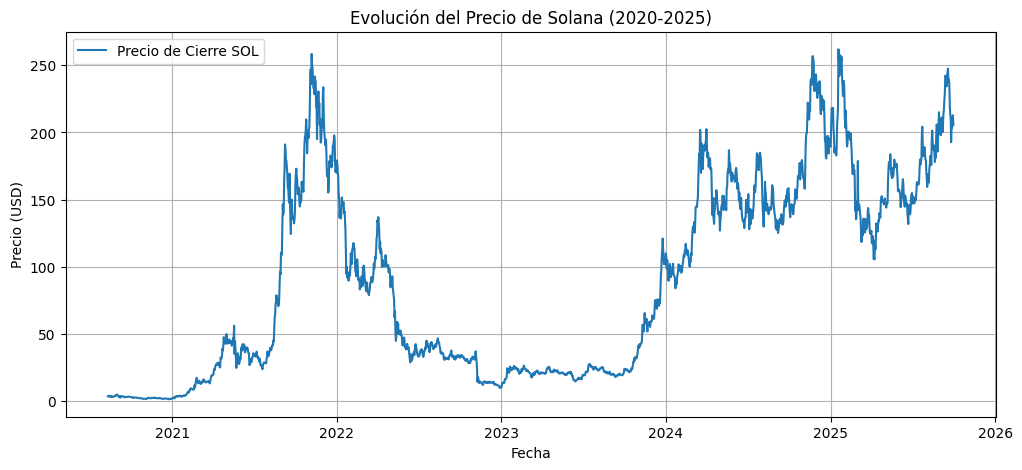

Estadísticas del Precio de Cierre:
count    1877.000000
mean       88.205028
std        73.020611
min         1.198000
25%        22.000000
50%        61.030000
75%       150.500000
max       261.970000
Name: Close, dtype: float64


In [16]:
# Cargar datos crudos para EDA

filepath = "data/sol_1d_data_2020_to_2025.csv"
df_raw = load_data(filepath)

plt.figure(figsize=(12, 5))
plt.plot(df_raw["Open time"], df_raw["Close"], label="Precio de Cierre SOL")
plt.title("Evolución del Precio de Solana (2020-2025)")
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")
plt.legend()
plt.grid(True)
plt.show()

print("Estadísticas del Precio de Cierre:")
print(df_raw["Close"].describe())


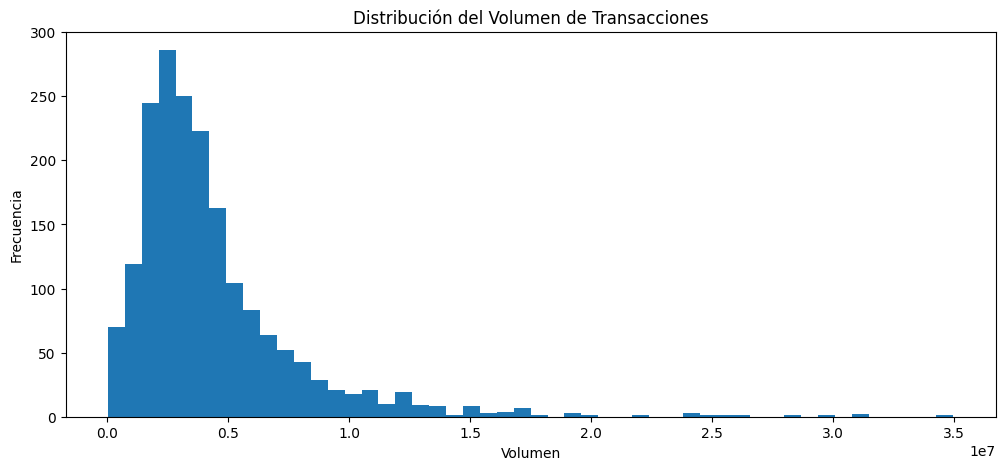

In [17]:
# Distribución del volumen

plt.figure(figsize=(12, 5))
plt.hist(df_raw["Volume"], bins=50)
plt.title("Distribución del Volumen de Transacciones")
plt.xlabel("Volumen")
plt.ylabel("Frecuencia")
plt.show()


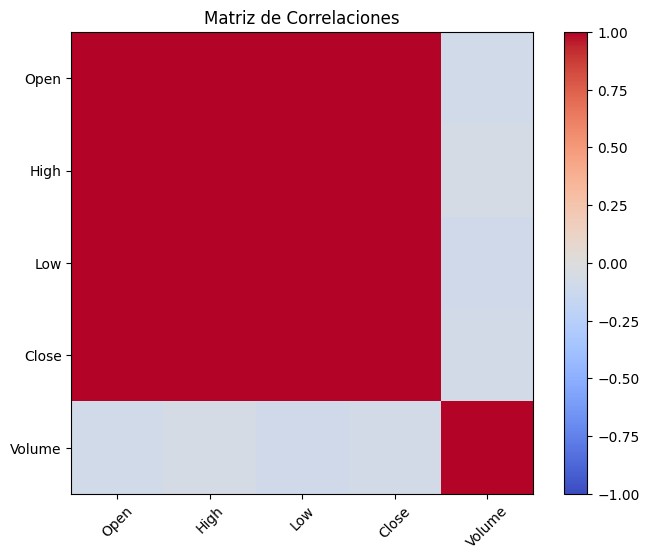

In [18]:
# Matriz de correlaciones

corr_matrix = df_raw[["Open", "High", "Low", "Close", "Volume"]].corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Matriz de Correlaciones")
plt.show()


### 3.2 Preprocesamiento e Ingeniería de Features (P5)

El preprocesamiento incluye limpieza de valores nulos, creación de retornos, medias móviles, volatilidad, rangos High-Low y normalización del volumen.

La implementación completa se encuentra en `src/data_handler.py`.


In [19]:
# Preprocesamiento de datos

df_features = prepare_features(df_raw, window=20)

print("Primeras filas de features:")
display(df_features.head())

df_features.to_csv("data/features_prepared.csv", index=False)


Primeras filas de features:


,Open time,Open,High,Low,Close,Volume,Returns,SMA20,SMA50,Volatility,HL_Range,Volume_MA,Volume_Norm
49,2020-09-29,2.9549,3.0270,2.8735,2.9505,950875.56,-0.003176,3.05730,3.292330,0.064256,0.052025,2.566595e+06,0.370481
50,2020-09-30,2.9447,2.9838,2.8228,2.8967,722757.83,-0.018234,3.02833,3.284294,0.064006,0.055580,2.384889e+06,0.303057
51,2020-10-01,2.8967,2.9889,2.6500,2.8669,1373061.59,-0.010288,3.00185,3.266516,0.063904,0.118211,2.342160e+06,0.586237
52,2020-10-02,2.8667,2.8873,2.4200,2.6232,2788493.11,-0.085005,2.96643,3.244380,0.066244,0.178141,2.423507e+06,1.150602
53,2020-10-03,2.6231,2.6708,2.5356,2.5439,547025.23,-0.030230,2.93061,3.227060,0.066355,0.053147,2.349620e+06,0.232814


### 3.3 Entrenamiento y Evaluación (P6, P7-P8, M3-M4)

El entrenamiento detallado se documenta en `02_Model_Training.ipynb`.  
En esta sección se cargan los modelos entrenados y se evalúan sobre el conjunto de test.


In [22]:
# Cargar o generar features preparadas con columnas del entrenamiento (basado en 02_Model_Training.ipynb)
import os
import numpy as np
import pandas as pd
from src.data_handler import load_data

prepared_path = 'data/features_prepared.csv'
if not os.path.exists(prepared_path):
    filepath = 'data/sol_1d_data_2020_to_2025.csv'
    df_raw = load_data(filepath)
    
    # Preprocesamiento exacto del entrenamiento
    features_df = df_raw[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Number of trades']].copy()
    features_df['Returns'] = features_df['Close'].pct_change()
    features_df['SMA20'] = features_df['Close'].rolling(window=20).mean()
    features_df['Volatility_20'] = features_df['Returns'].rolling(window=20).std()
    features_df['Target_Price'] = features_df['Close'].shift(-1)
    features_df['Target_Direction'] = np.where(features_df['Target_Price'] > features_df['Close'], 1, 0)
    
    features_df = features_df.dropna()
    features_df.to_csv(prepared_path, index=False)
    print("Generado features_prepared.csv con columnas del entrenamiento")
else:
    features_df = pd.read_csv(prepared_path)

# Split train/test (80/20)
split = int(len(features_df) * 0.8)
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Number of trades', 'Returns', 'SMA20', 'Volatility_20']  # Exactas del 02
target_col = 'Target_Price'

X = features_df[feature_cols]
y = features_df[target_col]
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Cargar modelos (compile=False para LSTM)
import tensorflow as tf
import pickle

model_dir = 'models'
rf_model = pickle.load(open(f'{model_dir}/rf_model_best.pkl', 'rb'))
lstm_model = tf.keras.models.load_model(f'{model_dir}/lstm_model.h5', compile=False)
scaler = pickle.load(open(f'{model_dir}/scaler.pkl', 'rb'))

# Predicciones RF
X_test_scaled = scaler.transform(X_test)
preds_rf = rf_model.predict(X_test_scaled)

# Predicciones LSTM
timesteps = 20
num_features = len(feature_cols)  # 9
pad_size = (timesteps - (X_test_scaled.shape[0] % timesteps)) % timesteps
X_test_padded = np.pad(X_test_scaled, ((0, pad_size), (0, 0)), mode='constant')
X_test_lstm = np.reshape(X_test_padded, (X_test_padded.shape[0] // timesteps, timesteps, num_features))
preds_lstm = lstm_model.predict(X_test_lstm).flatten()[:len(X_test)]

# Métricas
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

valid_idx = ~y_test.isna()
y_test_clean = y_test[valid_idx]
preds_rf_clean = preds_rf[valid_idx]
preds_lstm_clean = preds_lstm[valid_idx]

print("RF R2:", r2_score(y_test_clean, preds_rf_clean))
print("RF RMSE:", np.sqrt(mean_squared_error(y_test_clean, preds_rf_clean)))
print("LSTM R2:", r2_score(y_test_clean, preds_lstm_clean))
print("LSTM RMSE:", np.sqrt(mean_squared_error(y_test_clean, preds_lstm_clean)))

UnpicklingError: invalid load key, '\x07'.